In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import re
import random

In [2]:
def softmax(x, c=1):
    x = np.array(x)
    x = x - x.max()
    return np.exp(x*c)/np.sum(np.exp(x*c))

In [3]:
def apply_input(I_dict, training=False):
    global U1_hat, U2_hat, V1_hat, V2_hat
    
    
    output = {"input": [], "label": [], "target_vec": [], "index": [], "node": [],
              "r1_hat": [], "r2_hat": [], "r1_bar": [], "r2_bar": [],
              "U1_hat": [], "V1_hat": [],  "U2_hat": [], "V2_hat": [], "training": []}
    
    if training == True:
        I_order = random.sample(list(I_dict.keys()), len(list(I_dict.keys())))
    elif training == False:
        I_order = list(I_dict.keys())
    
    for k in I_order:
        I = I_dict[k]
        k_idx = list(I_dict.keys()).index(k)
        L = np.eye(len(I_dict))[k_idx]

        r1_hat = r1.copy()
        r2_hat = r2.copy()

        r1_bar = r1.copy()
        r2_bar = r2.copy()

        for idx in np.arange(I.shape[1]):
            output["r1_bar"].append(r1_bar.copy())
            output["r2_bar"].append(r2_bar.copy())

            node = np.arange(vec_len)

            r1_hat_old = r1_hat.copy()
            r2_hat_old = r2_hat.copy()

            U1_bar = U1_hat.copy()
            U2_bar = U2_hat.copy()

            V1_bar = V1_hat.copy()
            V2_bar = V2_hat.copy()

            r1_hat = r1_bar + Nr1/s10 * U1_bar.T @ (I[:, idx] - U1_bar @ r1_bar) - Nr1/s21 * (r1_bar - U2_bar @ r2_bar)
            r2_hat = r2_bar + Nr2/s21 * U2_bar.T @ (r1_bar - U2_bar @ r2_bar)

            if training == True:
                r2_hat = r2_bar + Nr2/s21 * U2_bar.T @ (r1_bar - U2_bar @ r2_bar) - 1/s32 * (softmax(r2_bar) - L)
                
                U1_hat = U1_bar + Nu1/s10 * np.outer(I[:, idx] - U1_bar @ r1_hat, r1_hat)
                U2_hat = U2_bar + Nu2/s21 * np.outer(r1_bar - U2_bar @ r2_hat, r2_hat)

                V1_hat = V1_bar + Nv1/s11 * np.outer(r1_hat - r1_bar, r1_hat_old)
                V2_hat = V2_bar + Nv2/s22 * np.outer(r2_hat - r2_bar, r2_hat_old)

            r1_bar = V1_bar @ r1_hat
            r2_bar = V2_bar @ r2_hat

            output["input"].append(I[:, idx])
            output["label"].append(k)
            output["target_vec"].append(L)
            output["index"].append(idx)
            output["node"].append(node)

            output["r1_hat"].append(r1_hat.copy())
            output["r2_hat"].append(r2_hat.copy())
            
            output["U1_hat"].append(U1_hat.copy())
            output["U2_hat"].append(U2_hat.copy())
            
            output["V1_hat"].append(V1_hat.copy())
            output["V2_hat"].append(V2_hat.copy())
            
            output["training"].append(training)
    
    output_df = pd.DataFrame.from_dict(output)
    
    return output_df

In [4]:
def raw_vs_softmax_plots(df, ncols, nrows, subplot_yx, scale, groupby, value, sharex=False, sharey=False, cmap=None):
    subplot_y, subplot_x = tuple(i * scale for i in (subplot_yx))

    fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharex=sharex, sharey=sharey)
    
    df_groupby = df.groupby(groupby)
    group_keys = df_groupby.groups.keys()
    
    for k in group_keys:
        k_idx = list(group_keys).index(k)

        raw_r = df_groupby.get_group(k).apply(lambda x: pd.Series(x[value]), axis=1).reset_index(drop=True)
        softmaxd_r = df_groupby.get_group(k).apply(lambda x: pd.Series(softmax(x[value])), axis=1).reset_index(drop=True)

        raw_r.columns = group_keys
        softmaxd_r.columns = group_keys

        raw_plot = raw_r.plot(ax=axes[k_idx, 0], title="{}: raw activations".format(k), cmap=cmap);
        softmaxd_plot = softmaxd_r.plot(ax=axes[k_idx, 1], title="{}: softmax'd activations".format(k), cmap=cmap);
        
        raw_plot.legend(loc="lower left");
        softmaxd_plot.legend(loc="lower left");
        
        # thicken target line
        for i, l1, l2 in zip(range(len(group_keys)), raw_plot.lines, softmaxd_plot.lines):
            if i == k_idx:
                plt.setp(l1, linewidth=3)
                plt.setp(l2, linewidth=3)

    plt.tight_layout();

In [5]:
def recon_plots(df, ncols, nrows, subplot_yx, scale, groupby, value, sharex=True, sharey=True, cmap="gray", y_label_list=None):
    subplot_y, subplot_x = tuple(i * scale for i in (subplot_yx))

    fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharex=sharex, sharey=sharey)

    df_groupby = df.groupby(groupby)
    group_keys = df_groupby.groups.keys()
    
    vmin = df.apply(lambda x: pd.Series(x[value]), axis=1).values.min()
    vmax = df.apply(lambda x: pd.Series(x[value]), axis=1).values.max()
    
    for k, ax in zip(group_keys, axes.flatten()):
        vall = df_groupby.get_group(k).apply(lambda x: pd.Series(x[value]), axis=1).values.T
        im = ax.imshow(vall, cmap=cmap, vmin=vmin, vmax=vmax)
    
        if y_label_list != None:
            ax.set_yticks(range(len(y_label_list)))
            ax.set_yticklabels(y_label_list)

        ax.set_title(k)

    fig.colorbar(im, ax=axes.ravel().tolist());

# Inputs

In [6]:
I_filenames = glob.glob("data/3x3/*.png")
I_dict = {}

for i in I_filenames:
    I = cv2.imread(i)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = I/255
    
    I_id = re.sub(r".*_(.*)\.png", r"\1", i)
    
    I_dict.update({I_id: I})

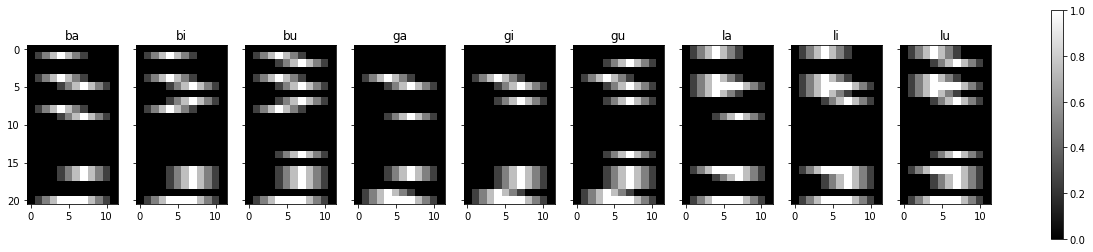

In [7]:
ncols = len(I_dict)
nrows = 1

subplot_y, subplot_x = I.shape
scale = 0.2
subplot_y, subplot_x = tuple(i * scale for i in (subplot_y, subplot_x))

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharex=True, sharey=True)

for k, ax in zip(I_dict.keys(), axes.flatten()):
    im = ax.imshow(I_dict[k], cmap="gray")
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

# Parameters

In [8]:
epoch_n = 1000
epoch_max = max(range(epoch_n))

vec_len = len(I_dict)
I_size = I.shape[0]
r1_size = 32
r2_size = vec_len

r1 = np.zeros(r1_size)
r2 = np.zeros(r2_size)

np.random.seed(1)
U1 = np.random.normal(loc=0, scale=0.1, size=(I_size, r1_size))
U2 = np.random.normal(loc=0, scale=0.1, size=(r1_size, r2_size))
V1 = np.random.normal(loc=0, scale=0.1, size=(r1_size, r1_size))
V2 = np.random.normal(loc=0, scale=0.1, size=(r2_size, r2_size))

s10 = 10
s11 = 1000
s21 = 1000
s22 = 1000
s32 = 10

Nr1 = 0.5
Nr2 = 0.5

Nu1 = 10
Nu2 = 10

Nv1 = 10
Nv2 = 10

# Before Training

In [9]:
U1_hat = U1.copy()
V1_hat = V1.copy()
U2_hat = U2.copy()
V2_hat = V2.copy()

output_test_df = apply_input(I_dict, training=False)

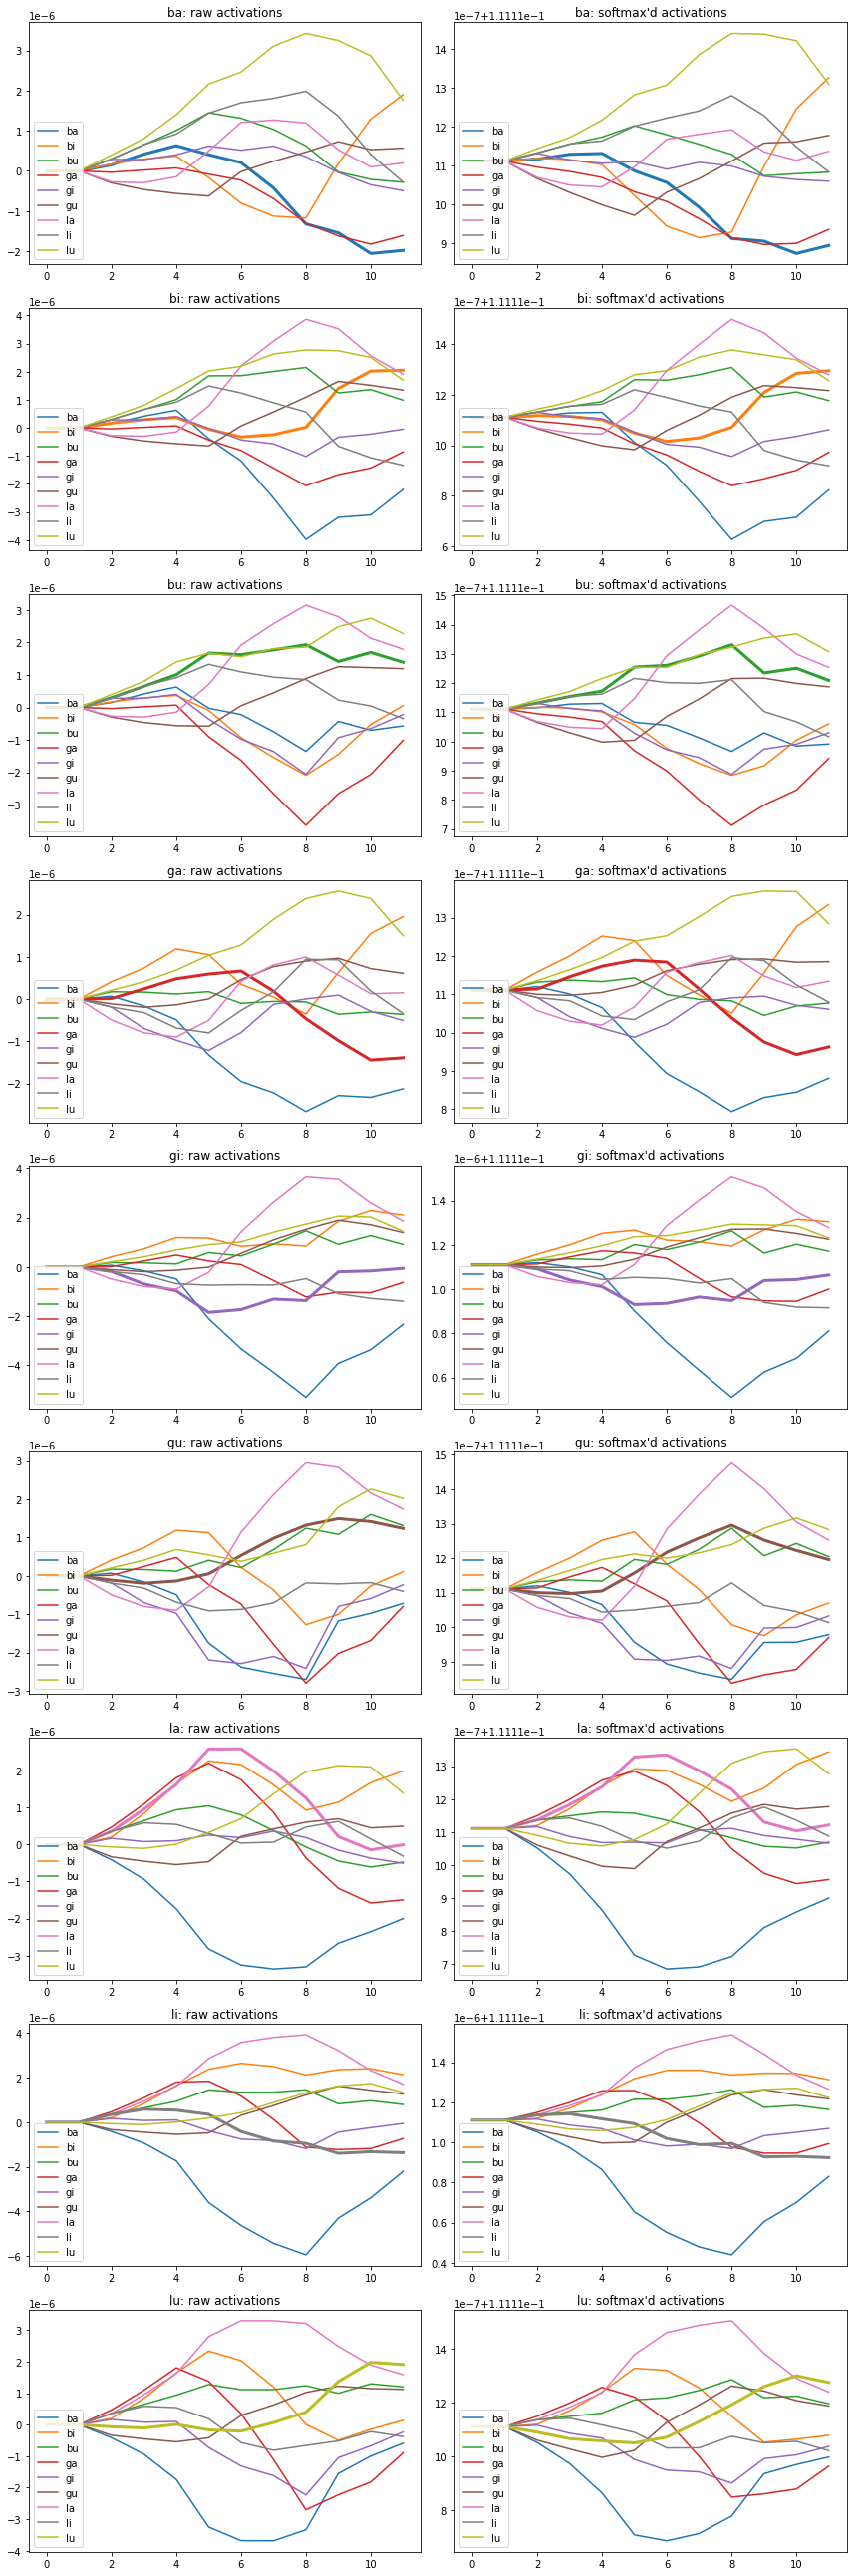

In [10]:
raw_vs_softmax_plots(df=output_test_df, ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat")

## Training

In [11]:
U1_hat = U1.copy()
V1_hat = V1.copy()
U2_hat = U2.copy()
V2_hat = V2.copy()

output_train_list = []

for epoch in np.arange(epoch_n):
    output_train_i = apply_input(I_dict, training=True)
    output_train_i["epoch"] = epoch
    output_train_list.append(output_train_i)
    
output_train_df = pd.concat(output_train_list)

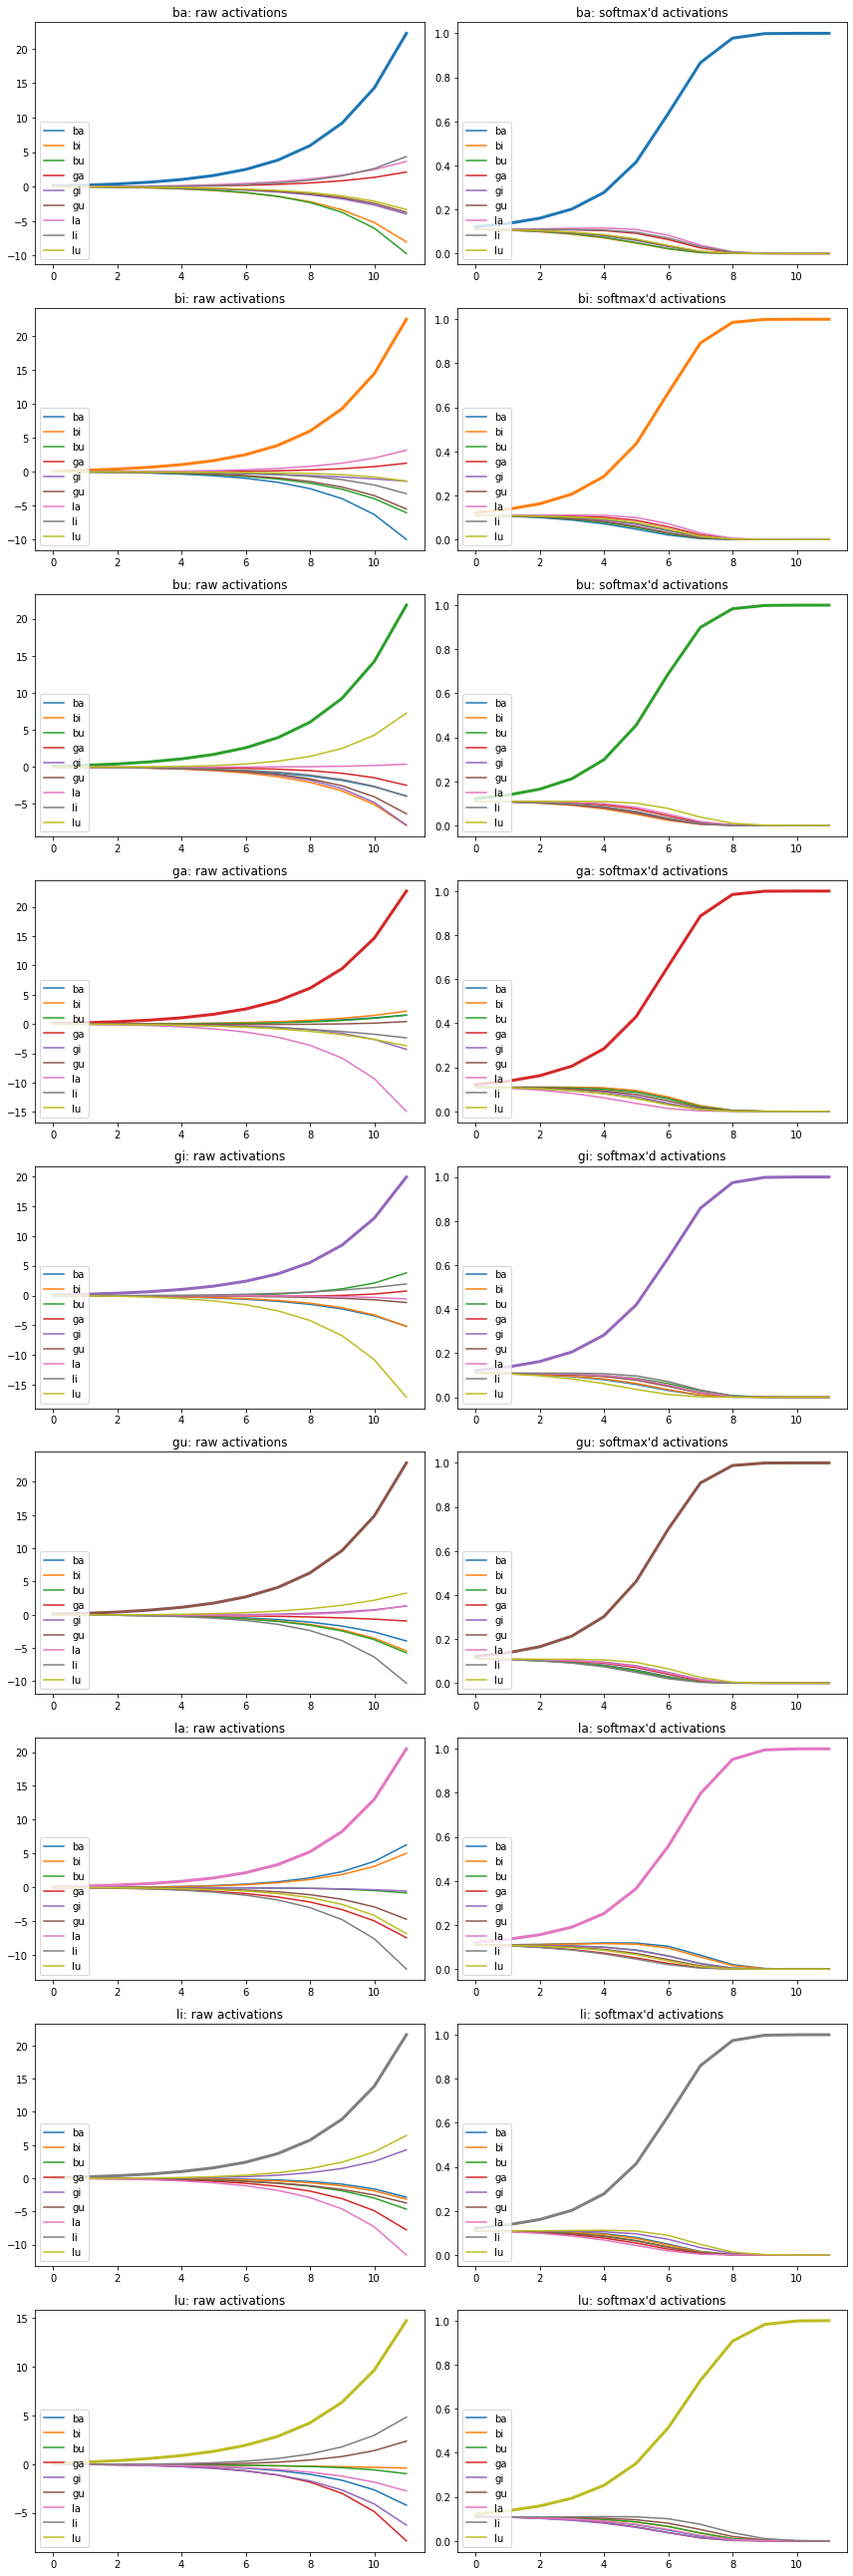

In [12]:
raw_vs_softmax_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat")

## Testing

In [13]:
output_test_df = apply_input(I_dict, training=False)

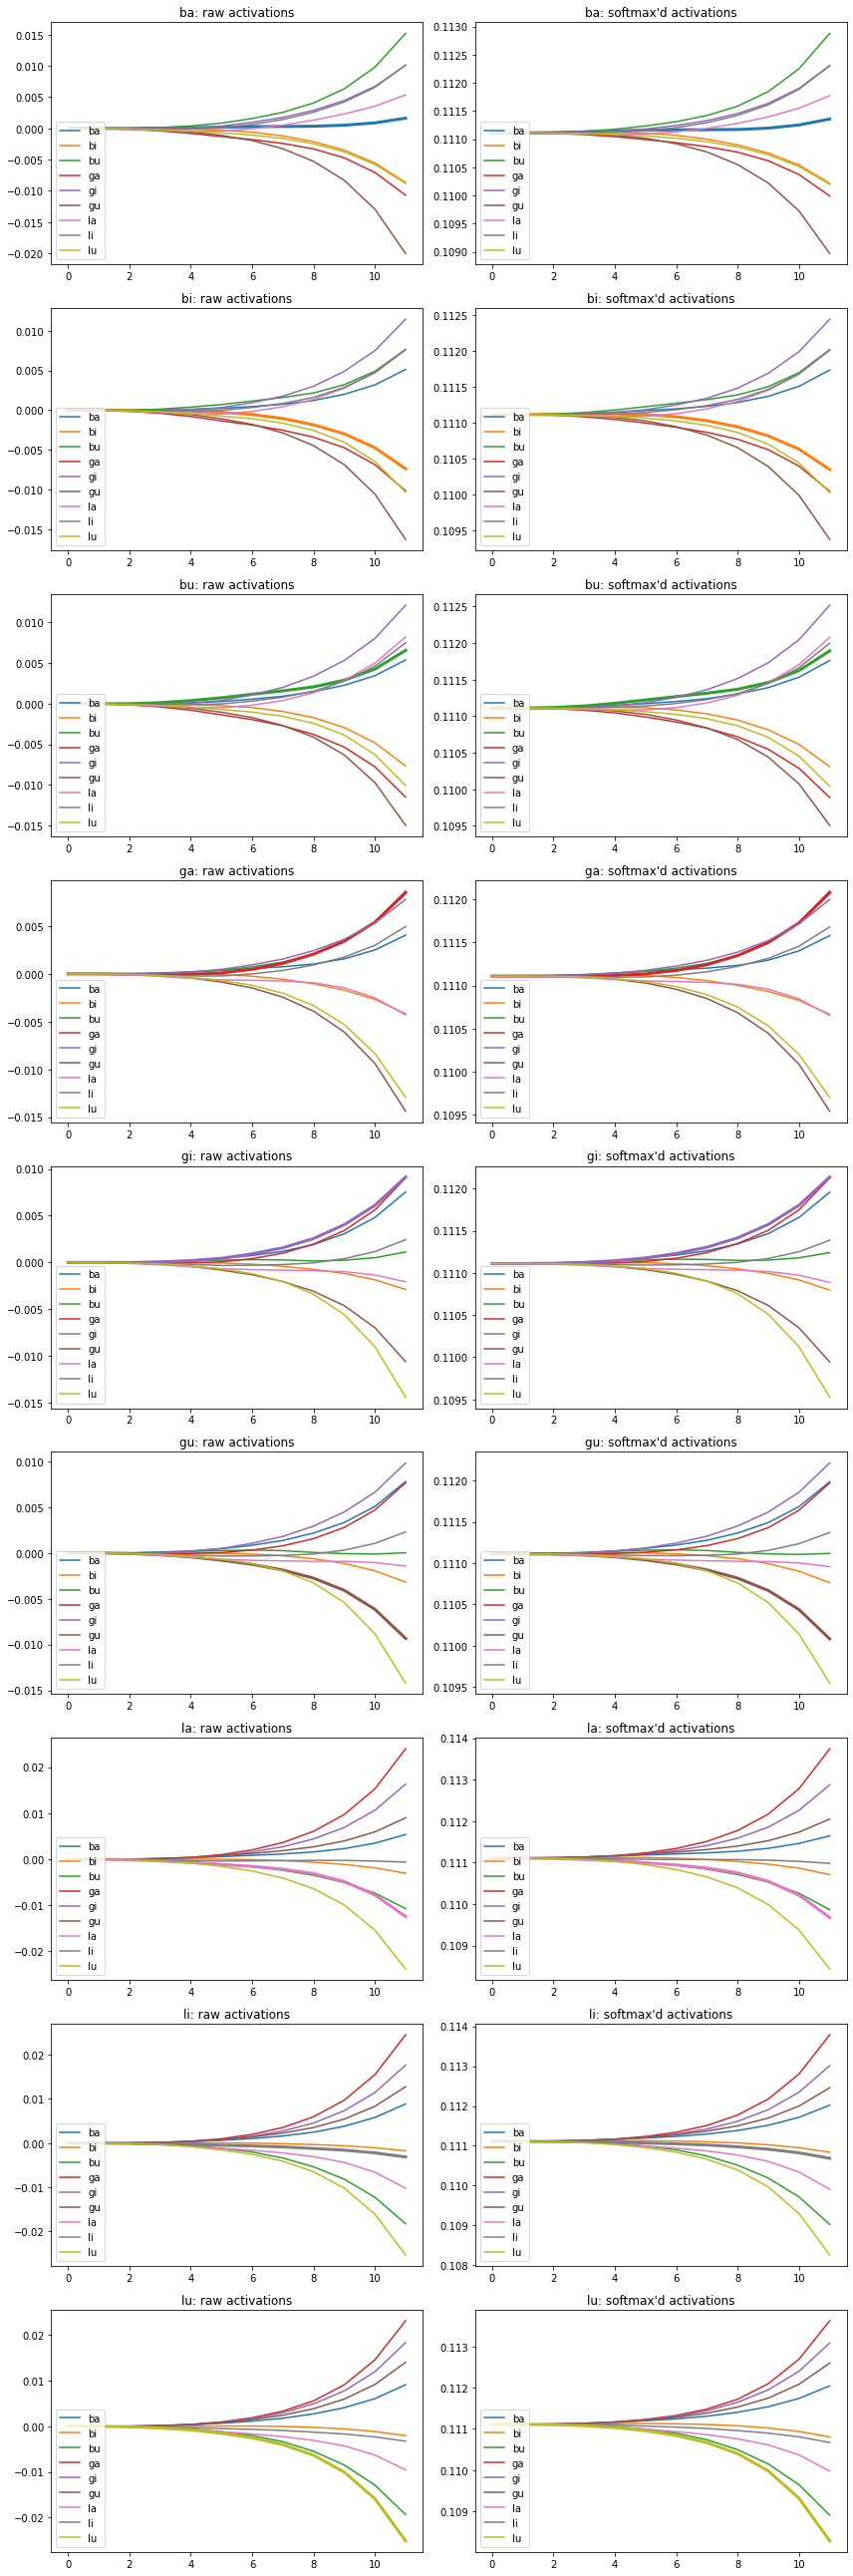

In [14]:
raw_vs_softmax_plots(df=output_test_df, ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="r2_hat")

# Input Reconstruction

## Actual Inputs

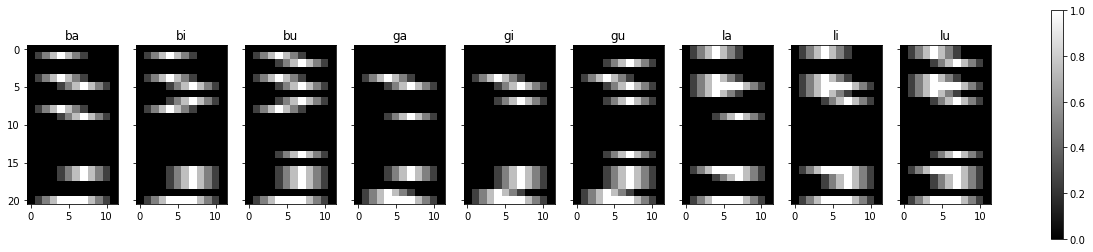

In [15]:
recon_plots(df=output_test_df, ncols=9, nrows=1, subplot_yx=(21,12), scale=0.2, groupby="label", value="input")

## Reconstruction Based on r1_hat

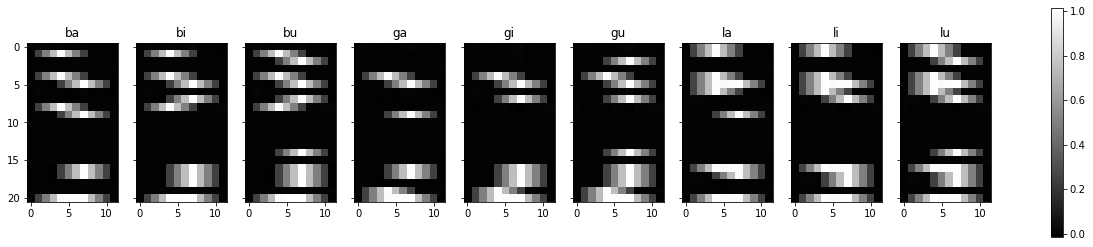

In [16]:
output_test_df["r1_hat_recon"] = output_test_df.apply(lambda x: x.U1_hat @ x.r1_hat, axis=1)

recon_plots(df=output_test_df, ncols=9, nrows=1, subplot_yx=(21,12), scale=0.2, groupby="label", value="r1_hat_recon")

## Reconstruction Based on r1_bar

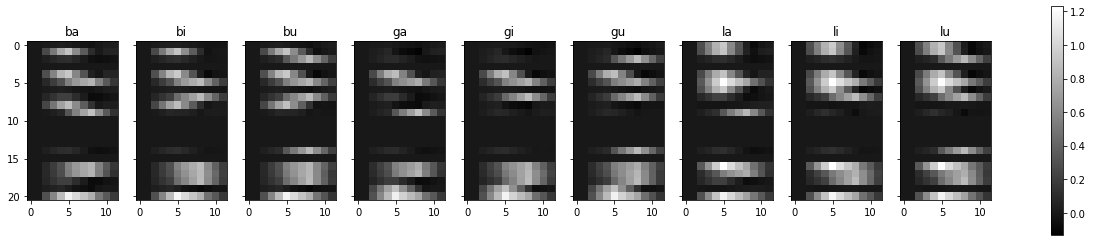

In [17]:
output_test_df["r1_bar_recon"] = output_test_df.apply(lambda x: x.U1_hat @ x.r1_bar, axis=1)

recon_plots(df=output_test_df, ncols=9, nrows=1, subplot_yx=(21,12), scale=0.2, groupby="label", value="r1_bar_recon")

## Differences of Reconstruction of r1_bar and r1_hat

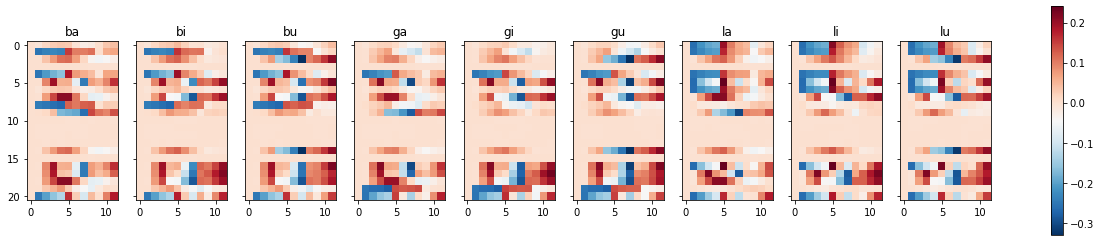

In [18]:
output_test_df["r1_recon_diff"] = output_test_df.apply(lambda x: x.r1_bar_recon - x.r1_hat_recon, axis=1)

recon_plots(df=output_test_df, ncols=9, nrows=1, subplot_yx=(21,12), scale=0.2, groupby="label", value="r1_recon_diff", cmap="RdBu_r")

# Target Reconstruction

## Actual Target Vector

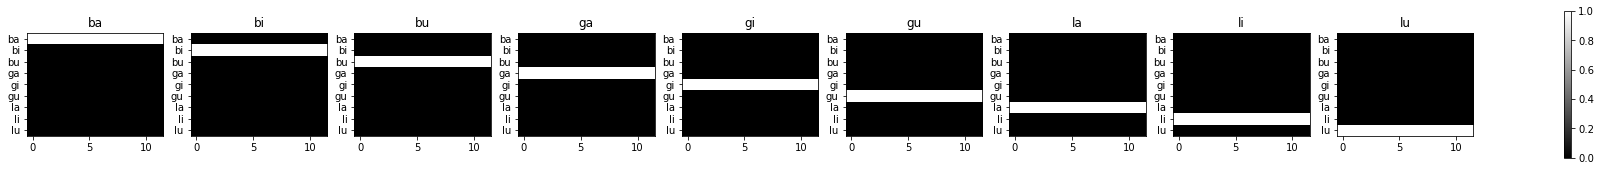

In [19]:
recon_plots(df=output_test_df, ncols=9, nrows=1, subplot_yx=(9,12), scale=0.3, groupby="label", value="target_vec",
            sharey=False, y_label_list=list(I_dict.keys()))

## Softmax'd r2_hat During Training

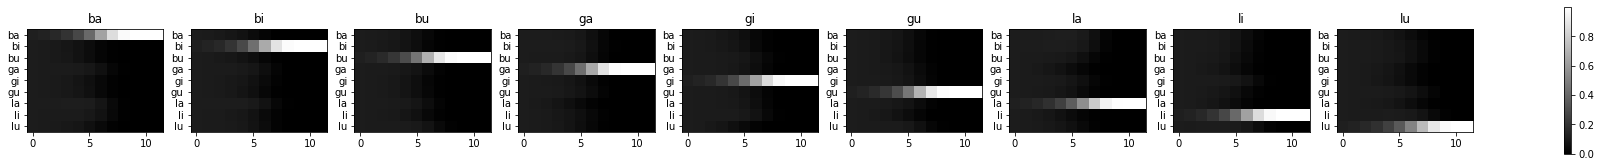

In [20]:
output_train_df["softmaxd_r2_hat"] = output_train_df.apply(lambda x: softmax(x.r2_hat), axis=1)

recon_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
            ncols=9, nrows=1, subplot_yx=(9,12), scale=0.3, groupby="label", value="softmaxd_r2_hat",
            sharey=False, y_label_list=list(I_dict.keys()))

## Softmax'd r2_hat During Testing

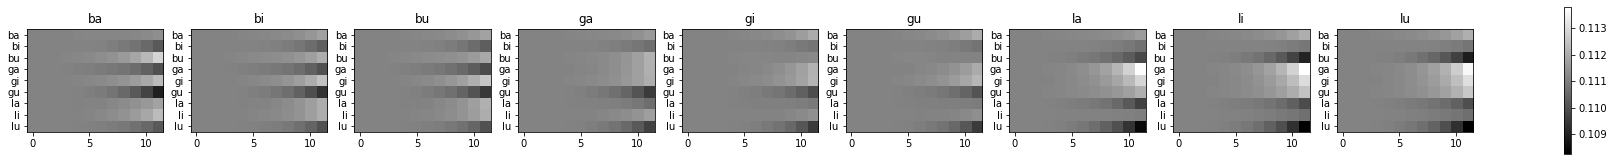

In [21]:
output_test_df["softmaxd_r2_hat"] = output_test_df.apply(lambda x: softmax(x.r2_hat), axis=1)

recon_plots(df=output_test_df, ncols=9, nrows=1, subplot_yx=(9,12), scale=0.3, groupby="label", value="softmaxd_r2_hat",
            sharey=False, y_label_list=list(I_dict.keys()))